# Transfer Learning Experiment with augmentation with 23 class - vgg16 scratch development


## Context
The data consists of images of 23 types of skin diseases taken from http://www.dermnet.com/dermatology-pictures-skin-disease-pictures. The total number of images are around 19,500, out of which approximately 15,500 have been split in the training set and the remaining in the test set.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Import Libraries

In [1]:
import datetime
import operator
##open cv
import cv2
from google.colab.patches import cv2_imshow
import random
#numpy-pandas
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
#visualization
import seaborn as sns
import matplotlib.pyplot as plt

#tensorflow and utilities
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import regularizers

#tensorflow model, layers, optimizers etc
from tensorflow.keras import Input 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, concatenate, AveragePooling2D, GlobalAveragePooling2D

#callbacks
from tensorflow.keras.callbacks import BaseLogger, CSVLogger, EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard, ReduceLROnPlateau

#pretrained models
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import  preprocess_input
from tensorflow.keras.applications.resnet import  preprocess_input

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score

#Loading TensorBoard
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/ 

## 2. Import Data

In [2]:
#getting dataframes of train and test data
train_df = pd.read_csv("/content/drive/MyDrive/Dermnet/Files/final_dataframe/final_train_df.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Dermnet/Files/final_dataframe/final_test_df.csv")

#setting up path
train_df["path"] = train_df["class"] + "/" + train_df["image_name"]
test_df["path"] = test_df["class"] + "/" + test_df["image_name"]

#getting shape
print("Shape of train dataset is {}.".format(train_df.shape))
print("Shape of test dataset is {}.".format(test_df.shape))

Shape of train dataset is (14523, 4).
Shape of test dataset is (3527, 4).


## 3. Class Selection

In [3]:
## getting y value for stratification
y = train_df["class"].values

## splitting of data
train_df_final, validation_df_final, ytrain, ytest = train_test_split(train_df, y, test_size=0.25, stratify=y, random_state=42)
print("Shape of train : {}.".format(train_df_final.shape))
print("Shape of test : {}.".format(validation_df_final.shape))

Shape of train : (10892, 4).
Shape of test : (3631, 4).


In [4]:
test_df["class_cat"] = test_df["class"].astype('category').cat.codes
y_true = test_df["class_cat"].values

## 4. Data Pipeline

In [20]:
channels = 3
batchsize = 32
num_classes = 23
img_rows = 128
img_cols = 128 

In [6]:
#datagwn without augmentation
datagen_aug = ImageDataGenerator(rescale=1./255,
                                 rotation_range=30,
                                 shear_range=0.3,
                                 width_shift_range=0.4,
                                 horizontal_flip=True,
                                 brightness_range=(0.2,0.5),
                                 fill_mode='nearest')

#Train Generator
train_generator = datagen_aug.flow_from_dataframe(dataframe = train_df_final, 
                                        directory="/content/drive/MyDrive/Dermnet/Images/train/", x_col="path", y_col="class", 
                                        class_mode="categorical", subset="training", shuffle=True,
                                        target_size=(img_rows, img_cols), 
                                        batch_size = batchsize, 
                                        color_mode='rgb',
                                        seed=42)

#Validation Generator
valid_generator = datagen_aug.flow_from_dataframe(dataframe = validation_df_final, 
                                        directory="/content/drive/MyDrive/Dermnet/Images/train/", x_col="path", y_col="class", 
                                        class_mode="categorical", subset="training", shuffle=True,
                                        target_size=(img_rows, img_cols), 
                                        batch_size = batchsize, 
                                        color_mode='rgb',
                                        seed=42)

Found 10892 validated image filenames belonging to 23 classes.
Found 3631 validated image filenames belonging to 23 classes.


## 5. Callbacks

In [7]:
earlyStopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True) 
#reduce learning rate
reduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=0.001)

## 6. Plot Functions

In [29]:
def loss_plot(train_loss, test_loss, total_epoch):
    """
    This function plots the loss graph of both train and validation dataset.
    """
    fig = plt.figure(figsize=(5,5))  #setting up figure size
    plt.plot(train_loss);  plt.plot(test_loss)
    #setting up ticks
    plt.xticks(range(1,total_epoch))
    plt.legend(["Train_Loss", "Validation_Loss"])
    #setting up labels
    plt.xlabel("Number of Epochs", fontsize=10)
    plt.ylabel("Log Loss", fontsize=10)
    plt.title("Loss Plot for train and validation dataset", fontsize=20)
    return plt.show()



def accuracy_plot(train_accuracy, test_accuracy, total_epoch):
    """
    This function plots the accuracy graph of both train and validation dataset.
    """
    fig = plt.figure(figsize=(5,5))  #setting up figure size
    plt.plot(train_accuracy);  plt.plot(test_accuracy)
    #setting up ticks
    plt.xticks(range(1,total_epoch))
    plt.legend(["Train_Accuracy", "Validation_Accuracy"])
    #setting up labels
    plt.xlabel("Number of Epochs", fontsize=10)
    plt.ylabel("Accuracy", fontsize=10)
    plt.title("Accuracy Plot for train and validation dataset", fontsize=20)
    return plt.show()


## 7. Training VGG16 on 23 class from scratch

In [22]:
clear_session() ##clearning previous run session cache

base_model = tf.keras.applications.VGG16(include_top = False, weights = None, input_shape = (256, 256, 3))
layer1 = base_model.output     #after model layer to get the output
layer2 = GlobalAveragePooling2D()(layer1)    #global max pooling
output_ = Dense(num_classes, activation = "softmax")(layer2)  #final dense layer with number of output

model = Model(base_model.input, output_)

In [21]:
epochs= 20
nb_train_samples = 10892 
nb_validation_samples = 3631

In [23]:
model = Model (inputs=input, outputs =output)

#compilation of model
model.compile(optimizer = Adam(lr = 0.001), loss = "categorical_crossentropy", metrics = ["accuracy"])

## 8. Training of Data

In [24]:
# fitting model
history = model.fit(train_generator, steps_per_epoch = nb_train_samples//batchsize, epochs=epochs, 
                    validation_data = valid_generator,
                    validation_steps=nb_validation_samples//batchsize,
                    callbacks = [earlyStopping, reduceLR])

Epoch 1/20
340/340 [==============================] - 8768s 26s/step - loss: 3.1697 - accuracy: 0.0843 - val_loss: 2.9858 - val_accuracy: 0.0888
Epoch 2/20
340/340 [==============================] - 142s 417ms/step - loss: 2.9876 - accuracy: 0.0895 - val_loss: 2.9809 - val_accuracy: 0.0832
Epoch 3/20
340/340 [==============================] - 142s 417ms/step - loss: 2.9908 - accuracy: 0.0859 - val_loss: 2.9856 - val_accuracy: 0.0932
Epoch 4/20
340/340 [==============================] - 141s 414ms/step - loss: 2.9855 - accuracy: 0.0883 - val_loss: 2.9812 - val_accuracy: 0.0926
Epoch 5/20
340/340 [==============================] - 141s 414ms/step - loss: 2.9818 - accuracy: 0.0849 - val_loss: 2.9790 - val_accuracy: 0.0888
Epoch 6/20
340/340 [==============================] - 141s 414ms/step - loss: 2.9837 - accuracy: 0.0879 - val_loss: 2.9786 - val_accuracy: 0.0932
Epoch 7/20
340/340 [==============================] - 141s 414ms/step - loss: 2.9865 - accuracy: 0.0937 - val_loss: 2.9777 - 

## 9 .Save Model

In [ ]:
# creates a HDF5 file
#model.save('/content/drive/MyDrive/Dermnet/SavedModels/expeiment11.h5')

In [25]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0   

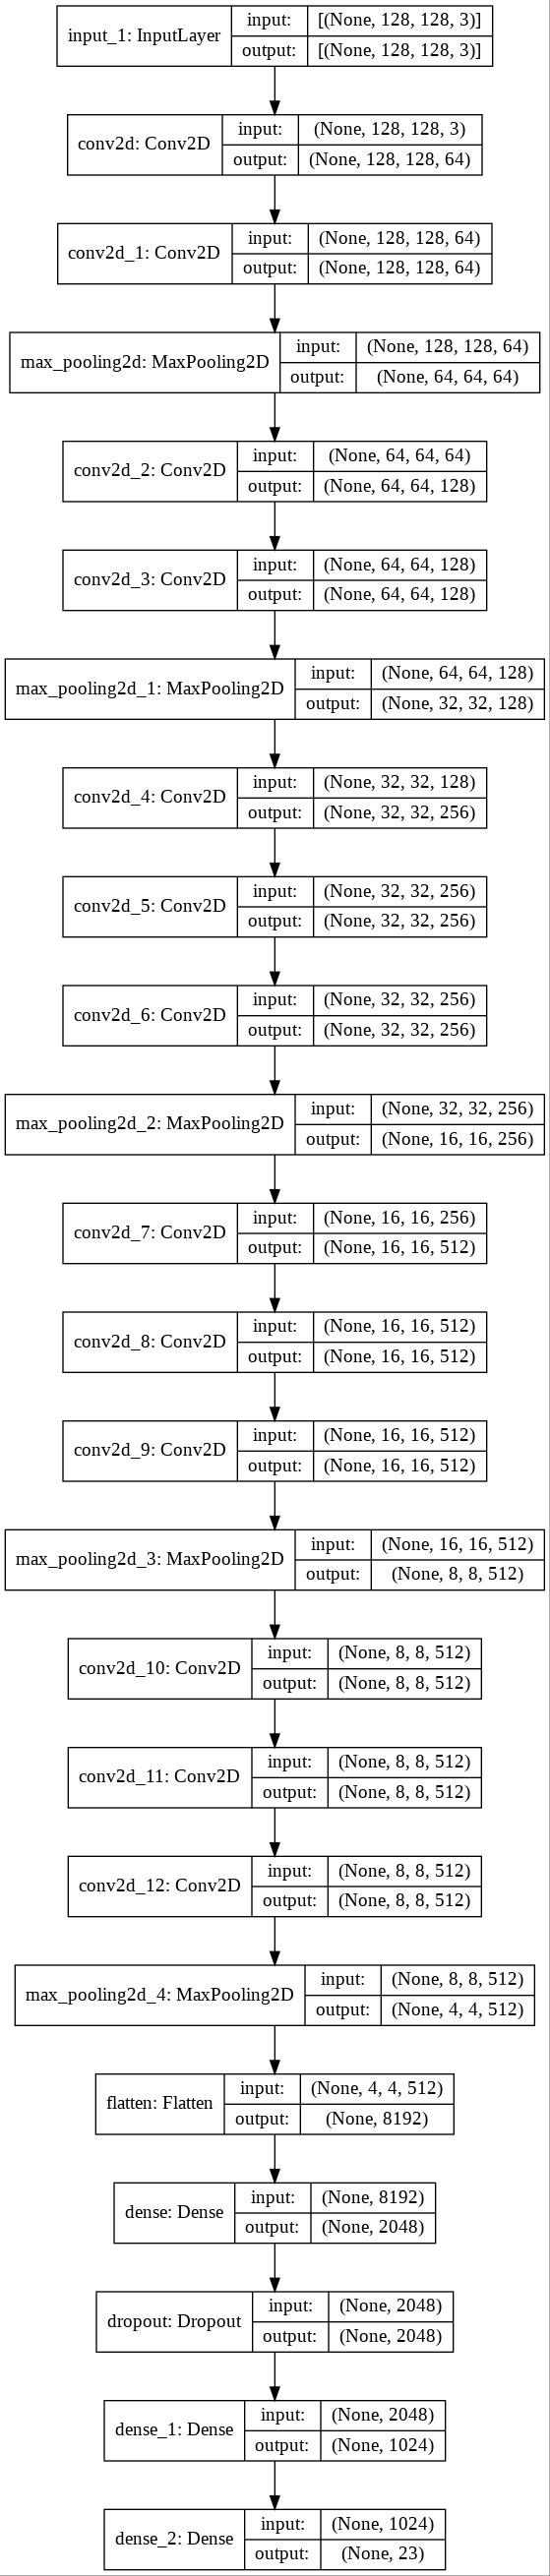

In [26]:
tf.keras.utils.plot_model(model, to_file="experiment11.jpg", show_shapes=True)

## 10. Loss and Accuracy Plot

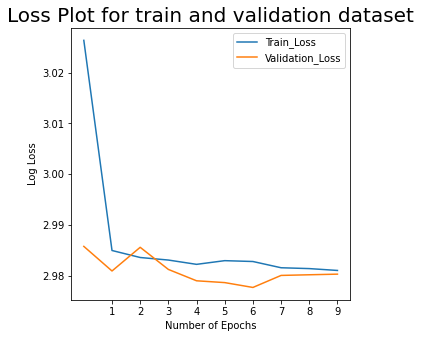

In [30]:
loss_plot(history.history["loss"], history.history["val_loss"], 10)

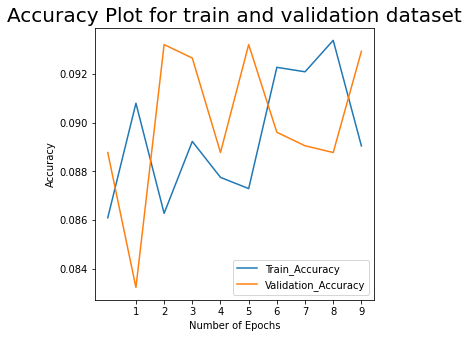

In [32]:
accuracy_plot(history.history["accuracy"], history.history["val_accuracy"], 10)

## 11. Prediction 

In [34]:
#Validation Generator
test_generator = datagen_aug.flow_from_dataframe(dataframe = test_df, 
                                            directory="/content/drive/MyDrive/Dermnet/Images/test/", 
                                            x_col="path", 
                                            y_col=None, 
                                            class_mode=None,
                                            subset=None,
                                            shuffle=False,
                                            target_size=(img_rows, img_cols),
                                            batch_size = batchsize,
                                            color_mode='rgb')

#predicting all values
output_scores = model.predict_generator(test_generator)

Found 3527 validated image filenames.


## 12. Evaluation Metric

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.00      0.00      0.00       283
           2       0.00      0.00      0.00       120
           3       0.00      0.00      0.00       113
           4       0.00      0.00      0.00        70
           5       0.00      0.00      0.00       300
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00        46
           8       0.00      0.00      0.00        86
           9       0.00      0.00      0.00       137
          10       0.00      0.00      0.00       100
          11       0.00      0.00      0.00       115
          12       0.00      0.00      0.00       210
          13       0.00      0.00      0.00        59
          14       0.10      1.00      0.18       339
          15       0.00      0.00      0.00        92
          16       0.00      0.00      0.00       339
          17       0.00    

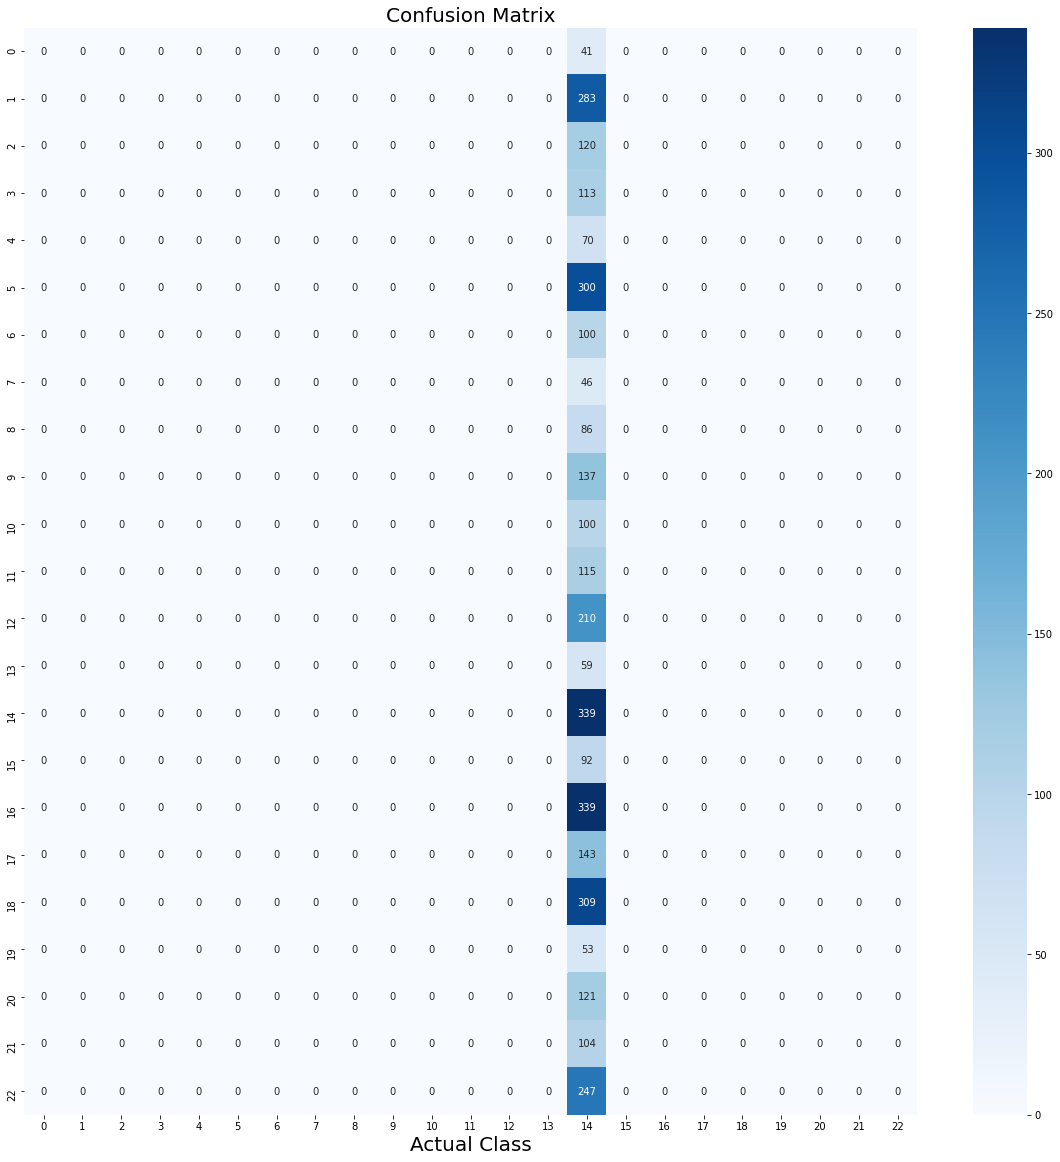

In [36]:
#getting output scores
class_outputs = [max(enumerate(val), key=operator.itemgetter(1)) for val in output_scores]
#getting prediction values
y_pred = [val[0] for val in class_outputs]


#getting confusion metrix
conf_matrix = confusion_matrix(y_true, y_pred)

#getting classification report 
print(classification_report(y_true, y_pred))

fig = plt.figure(figsize=(20,20))
sns.heatmap(conf_matrix, annot=True, cmap ="Blues", fmt="d")
plt.xlabel("Predicted Class", fontsize=20)
plt.xlabel("Actual Class", fontsize=20)
plt.title("Confusion Matrix", fontsize=20)
plt.show()